# Beyond a one-dimensional sequence
The Sequencer is essentially a dimensionality reduction algorithm, since it provides a one-dimensional embedding of the input dataset. This is one of the main differences between the Sequencer and other dimensionality reduction algorithms, such as tSNE and UMAP, which can embed the input dataset into higher dimensions as well (2D or 3D). In this notebook, I show how we can go beyond a one-dimensional sequence using a method somewhat similar to PCA: once we detect the main trend in the data, we can 'strip' it from the data, and apply the Sequencer to the residual dataset to look for the second strongest trend. <br>
The notebook is divided into the following parts: <br>
1. **Simulating a dataset with two sequences:** in this part of the notebook we will simulate a dataset with two unrelated sequences. The dataset will be built in a way that one sequence is more significant than the other. <br>
2. **Finding the strongest trend:** we will apply the Sequencer to the simulated dataset to find the strongest trend in the data. <br>
3. **Stripping the main trend from the data:** I will show how we can strip the main trend from the data, by constructing a smoothed version of the ordered dataset, and subtracting (or dividing) it from the original data. This results in a residual dataset that is stripped out of the main trend. <br>
4. **Finding the second strongest trend:** we will then apply the Sequencer to the residual data with the goal of detecting the second strongest trend. <br>

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [1]:
#!conda install numpy scipy networkx matplotlib
#!pip install TheSequencer

In [2]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from scipy.stats import chi2

import sequencer

## Simulate a dataset with two unrelated sequences
In this part of the notebook we will simulate a dataset with two unrelated sequences. The first, strongest, sequence will be driven by large-scale variations of the intensity. The second, weaker, sequence will be driven by weak pulses with a varying location. <br><br>
We will start by simulating the large-scale variation using the $\chi^{2}(k)$ distribution. This distribution changes smoothly as a function of its parameter, $k$, which I define using `df_list` and `df_val` as can be seen below. Additional information about the distribution can be found [here](https://en.wikipedia.org/wiki/Chi-squared_distribution). Users are encouraged to try additional functions to describe the large-scale variation. 

In [94]:
x = numpy.linspace(0.01, 10, 200)

df_list = numpy.linspace(0.1, 3, 200)
y_list = []
for i, df_val in enumerate(df_list):
    y = chi2.pdf(x, df_val)
    y_list.append(y)

y_list = numpy.array(y_list)
print(y_list.shape)

(200, 200)


I will now take the logarithm of the values, and will then rescale the array to be positive:

-4.42589176375356


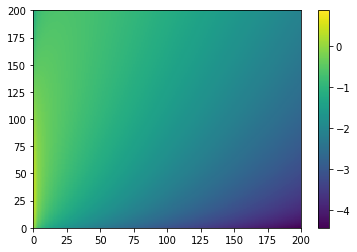

In [95]:
y_list_log = numpy.log10(y_list)
print(numpy.min(y_list_log))

plt.pcolormesh(y_list_log)
plt.colorbar()

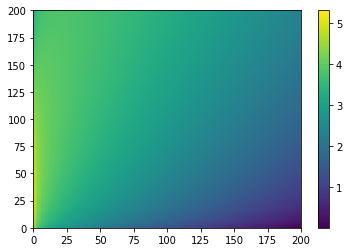

In [96]:
y_list_log_pos = 4.43 + y_list_log

plt.pcolormesh(y_list_log_pos)
plt.colorbar()

Before adding the second, unrelated, sequence, I will shuffle the dataset:

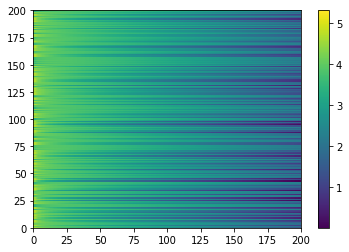

In [97]:
indices = numpy.arange(len(y_list_log_pos))
numpy.random.shuffle(indices)
y_list_shuffled = y_list_log_pos[indices, :]

plt.pcolormesh(y_list_shuffled)
plt.colorbar()

Now we will add several *very weak* emission lines on top of the varying continuum. These weak emission lines will form the second, unrelated sequence:

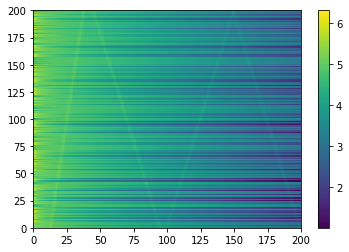

In [98]:
x = numpy.linspace(0, 400, 200)

# narrow pulses properties
mu_list_1 = numpy.linspace(25*2, 50*2, 200) - 25
mu_list_2 =  numpy.linspace(190, 90, 200)
mu_list_3 = numpy.linspace(100*2, 150*2, 200)
mu_list_4 = numpy.linspace(400, 150*2, 200)
sigma_val = 2.

objects_list = []
for i in range(200):
    # define the continuum
    continuum_val = y_list_shuffled[i]
    
    # define iid Gaussian noise that you will add to these objects
    noise = numpy.random.normal(loc=0, scale=0.005, size=len(continuum_val))
    
    # define the narrow pulses
    mu_val_1 = mu_list_1[i]
    mu_val_2 = mu_list_2[i]
    mu_val_3 = mu_list_3[i]
    mu_val_4 = mu_list_4[i]
    narrow_pulses = 0.2 * numpy.exp(-(mu_val_1 - x)**2/(2*sigma_val**2)) + \
                    0.2 * numpy.exp(-(mu_val_2 - x)**2/(2*sigma_val**2)) + \
                    0.2 * numpy.exp(-(mu_val_3 - x)**2/(2*sigma_val**2)) + \
                    0.2 * numpy.exp(-(mu_val_4 - x)**2/(2*sigma_val**2))
    
    # define the total object
    total_object = 1. + continuum_val + noise + narrow_pulses
    objects_list.append(total_object)
    
objects_list = numpy.array(objects_list)

plt.pcolormesh(objects_list)
plt.colorbar()

Shuffle the dataset one last time to obtain the final dataset which will serve as the input to the Sequencer:

In [99]:
indices = numpy.arange(len(objects_list))
numpy.random.shuffle(indices)

objects_list_shuffled = objects_list[indices]
grid = numpy.copy(x)

## Finding the strongest trend
We will now apply the Sequencer to the simulated dataset with the goal od detecting the main trend. For that, we will run the Sequencer with its default settings as follows:

In [100]:
# apply the Sequencer to this data
estimator_list = ['EMD', 'energy', 'KL', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path)
print("resulting elongation for the Sequencer: ", final_elongation)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 2.4789981842041016 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 3.8991401195526123 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 6.667340993881226 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 14.338704109191895 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 2.312382936477661 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 4.153151035308838 seconds
calculating the distance matrices for estimator: energy, scale: 4
finished calculating this distance matrix list, i

/anaconda3/lib/python3.7/site-packages/sequencer/sequencer_.py:945: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>
resulting elongation for the Sequencer:  19.5724


Since we do not know on which scales and through which metric the sequence is the strongest, it is always useful to print the intermediate elongations and to compare them to the final elongation obtained when averaging the different estimators:

In [101]:
# print all the metrics and scales, and examine the intermediate elongations
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 193.99
metric=EMD, scale=2, elongation: 107.46
metric=EMD, scale=4, elongation: 62.23
metric=EMD, scale=8, elongation: 39.54
metric=energy, scale=1, elongation: 194.61
metric=energy, scale=2, elongation: 97.77
metric=energy, scale=4, elongation: 39.15
metric=energy, scale=8, elongation: 25.57
metric=KL, scale=1, elongation: 32.63
metric=KL, scale=2, elongation: 23.53
metric=KL, scale=4, elongation: 35.24
metric=KL, scale=8, elongation: 31.89
metric=L2, scale=1, elongation: 32.4
metric=L2, scale=2, elongation: 17.37
metric=L2, scale=4, elongation: 28.43
metric=L2, scale=8, elongation: 31.54


**What can we see?** <br>
We see that the resulting elongation obtained separately for `(metric=EMD, scale=1)` and `(metric=energy, scale=1)` is larger than the final elongation we obtained when averaging all the estimators and scales. This means that the information about the perfect sequence (as traced by EMD and enegy, scale 1) is diluted by the other estimators. This effect was discussed in the notebook `basic_sequencer_functionalities.ipynb`. <br><br>
To avoid the effect of dilution, let's use only `metric=EMD` and `scale=1` to obtain the final sequence. Alternatively, as I showed in the notebook `basic_sequencer_functionalities.ipynb`, we can choose to average only the $N$ best estimators, and thus avoid the dilution. Since we have already calculated the distance matrices, we can just load them into memory as follows:

In [102]:
estimator_list = ['EMD']
scale_list = [[1]]
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list, scale_list)

# I just calculated the distance matrices, so no need to calculate them again
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_calculate_distance_matrices=False,
                                               to_save_distance_matrices=False,
                                               distance_matrices_inpath="%s/distance_matrices.pkl" % output_path)
print("resulting elongation for the Sequencer: ", final_elongation)

strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
dumped the elongations to the file: sequencer_output_directory/elongations.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>
resulting elongation for the Sequencer:  193.9914


As expected, the resulting elongation is now much larger. Let's reorder the input dataset according to the detected sequence:

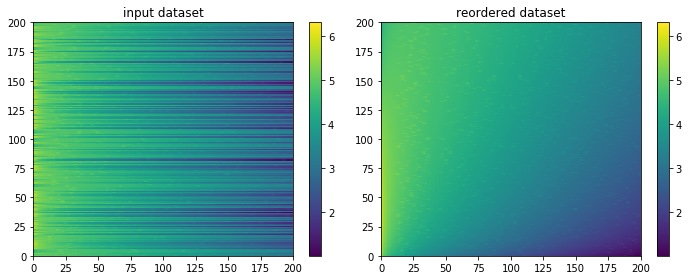

In [103]:
objects_list_reordered = objects_list_shuffled[final_sequence, :]

plt.figure(1, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("reordered dataset")
plt.pcolormesh(objects_list_reordered)
plt.colorbar()

plt.tight_layout()

We have detected the main sequence in the dataset, which is driven by large-scale variation of the intensity. <br>
Before moving on to searching for the next trend in the data, let's save the first sequence with an informative name, which we will use at the end of this notebook:

In [104]:
first_sequence = numpy.copy(final_sequence)

## Stripping the main trend from the data
Once we have detected the main trend in the data, we can strip it from the data and obtain a residual dataset as follows:<br>
1. Using the ordered dataset, we calculate its smoothed version by applying a median filter to it. This smoothing results in a "model" for the main trend detected in the data. The size of the median filter is a free parameter of course, and we can explore different kernel sizes and their effect on the final result. In this particular case, different kernel sizes will give roughly the same results. <br> **Important note:** we will use `scipy.signal.medfilt(objects_list_reordered, kernel_size)` to smooth the ordered dataset, which is represented by a two-dimensional array. Since this is a two dimensional array, `kernel_size` is a two-dimensional array as well, of the form: `kernel_size=(size_y, size_x)`, where `size_y` represents the window size for the median in the vertical direction, while `size_x` represents the window size for the median in the horizontal direction. Since we are interested in a median filter in the vertical direction alone (which is the sequence direction, we do not want to smooth the information along the horizontal direction, which represents different pixels in the same object), we will set `size_x=1`. We will therefore use a kernel of the form: `kernel_size=(size_y, 1)`.<br><br>
2. Once we have a smoothed version of the data, which represents the main trend in the data, we can subtract or divide it out of the data. We will therefore apply one of the following: `residual_data = ordered_data - smoothed_data` or `residual_data = ordered_data / smoothed_data`. Each of these will result in residuals that are more sensitive to different aspects of the data. When we subtract the smoothed version, we are more sensitive to additive information, and when we divide by the smoothed version, we are more sensitive to multiplicative information. The users are encouraged to try both of them and see what it looks like. For this particular example, both choices are ok, and we will detect the secondary sequence.

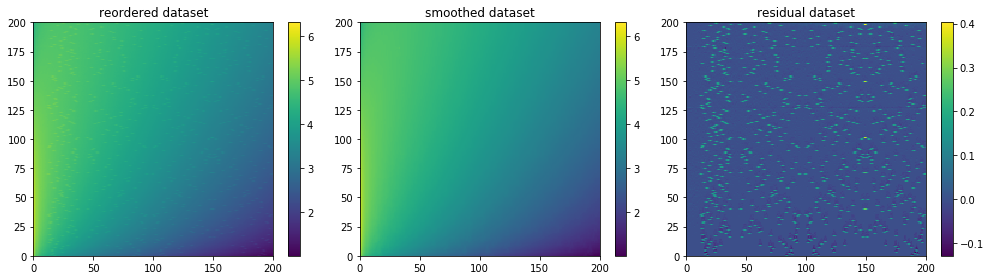

In [105]:
from scipy.signal import medfilt

objects_list_reordered_smoothed = medfilt(objects_list_reordered, kernel_size=[11, 1])
objects_list_residual = objects_list_reordered - objects_list_reordered_smoothed

plt.figure(1, figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.title("reordered dataset")
plt.pcolormesh(objects_list_reordered)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("smoothed dataset")
plt.pcolormesh(objects_list_reordered_smoothed)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("residual dataset")
plt.pcolormesh(objects_list_residual)
plt.colorbar()

plt.tight_layout()

We can see that the residual dataset contains some small scale information that we could not see in the ordered dataset. We could not see this small scale infrormation because its amplitude, roughly 0.3, is an order of magnitude smaller than the magnitude of the large-scale variation. We will try to apply the sequencer to this residual information and look for trends there. <br>
Before that, we need to rescale the residual dataset to be positive:

-0.12848736174443265


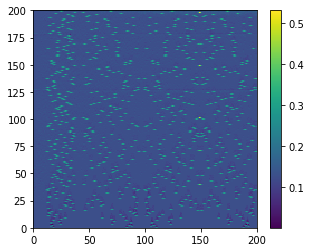

In [108]:
min_value = numpy.min(objects_list_residual)
print(min_value)

objects_list_residual_pos = 0.0001 + (-1 * min_value) + objects_list_residual

plt.figure(1, figsize=(5, 4))
plt.pcolormesh(objects_list_residual_pos)
plt.colorbar()

## Finding the second strongest trend
We will now apply the Sequencer to the residual dataset. Since we do not know a-priori on which scales the relevant information might be (and using which metric), we will try all four metrics and will use the default set of scales. After the Sequencer run, we will examine the different elongations and see where the information is. 

In [109]:
estimator_list = ['EMD', 'energy', 'KL', 'L2']
seq = sequencer.Sequencer(grid, objects_list_residual_pos, estimator_list)

output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path)
print("resulting elongation for the Sequencer: ", final_elongation)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 2.859037160873413 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 4.11316990852356 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 7.808120965957642 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 19.922399044036865 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 2.7878928184509277 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 4.728742837905884 seconds
calculating the distance matrices for estimator: energy, scale: 4
finished calculating this distance matrix list, it 

/anaconda3/lib/python3.7/site-packages/sequencer/sequencer_.py:945: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>
resulting elongation for the Sequencer:  162.52134999999998


print all the metrics and scales, and examine the intermediate elongations:

In [110]:
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 19.52
metric=EMD, scale=2, elongation: 24.56
metric=EMD, scale=4, elongation: 41.75
metric=EMD, scale=8, elongation: 52.91
metric=energy, scale=1, elongation: 41.67
metric=energy, scale=2, elongation: 50.89
metric=energy, scale=4, elongation: 60.21
metric=energy, scale=8, elongation: 75.59
metric=KL, scale=1, elongation: 148.66
metric=KL, scale=2, elongation: 152.33
metric=KL, scale=4, elongation: 151.45
metric=KL, scale=8, elongation: 150.93
metric=L2, scale=1, elongation: 162.52
metric=L2, scale=2, elongation: 162.52
metric=L2, scale=4, elongation: 162.53
metric=L2, scale=8, elongation: 166.45


We can see that the final elongation we obtained when averaging all the scales and estimators, 157.44, is of the same order as the intermediate elongations we obtained for the different metrics and scales. The final elongation is quite high, which suggests that we have detected a strong sequence in the residuals. <br>
Let's reorder the residuals according to the detected sequence:

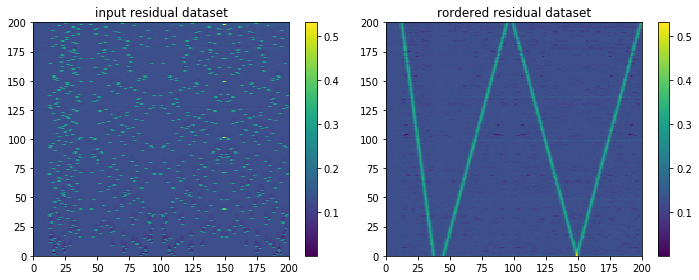

In [111]:
obejcts_list_residual_reordered = objects_list_residual_pos[final_sequence, :]

plt.figure(1, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("input residual dataset")
plt.pcolormesh(objects_list_residual_pos)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("rordered residual dataset")
plt.pcolormesh(obejcts_list_residual_reordered)
plt.colorbar()

plt.tight_layout()

We have detected the secondary sequence!!! :) <br>
Let's save the secondary sequence with an informative name: 

In [115]:
second_sequence_with_respect_to_first_sequence = numpy.copy(final_sequence)
second_sequence = first_sequence[final_sequence]

Using both of the sequences, we can now visualize the original dataset, ordered according to both of them. These are the two unrelated sequences we found:

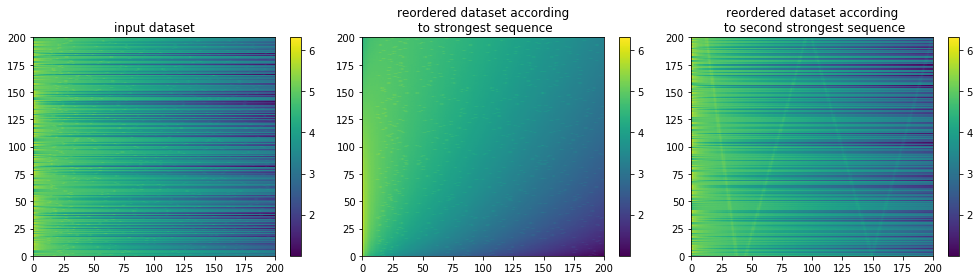

In [116]:
obejcts_list_ordered_first_sequence = objects_list_shuffled[first_sequence, :]

objects_list_ordered_second_sequence = objects_list_shuffled[second_sequence, :]

plt.figure(1, figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("reordered dataset according\n to strongest sequence")
plt.pcolormesh(obejcts_list_ordered_first_sequence)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("reordered dataset according\n to second strongest sequence")
plt.pcolormesh(objects_list_ordered_second_sequence)
plt.colorbar()

plt.tight_layout()